In [ ]:

import sys
print(sys.version)

In [1]:
import subprocess
import pysam
import pandas as pd
from pandas.api.types import CategoricalDtype 

import numpy as np
import glob, tqdm, os, shutil
from plotnine import *
import plotnine
import tqdm
from multiprocessing import Pool
from natsort import natsorted
import HTSeq

import scanpy.api as sc
import anndata as ad
from scipy import sparse

import genomeview
import random

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def count_lines(file):
    with open(file, 'r') as infile:
        for idx, line in enumerate(infile):
            pass
    return idx+1

def find_segment(df):
    """
    Takes coverage df
    Finds all segments passing filter
    Takes intagral of segment reads
    Returns ref pos of largest integral
    """
    previous_element = None
    track_counter = 0
    track_dict = {}
    for idx, element in enumerate(df['passing']):

        if element == True:
            track_counter += 1
            if track_counter == 1:
                start = idx
        else:
            track_counter = 0
            if previous_element == True:
                end = idx
                df_slice = df.iloc[start:end, :]
                sum_piles = df_slice['cov'].sum()
                track_dict[sum_piles] = (df.iloc[start,:]['refpos'], df.iloc[end,:]['refpos'])
        
        previous_element = element
    if element == True:
        end = idx
        df_slice = df.iloc[start:end, :]
        sum_piles = df_slice['cov'].sum()
        track_dict[sum_piles] = (df.iloc[start,:]['refpos'], df.iloc[end,:]['refpos'])
    
    if len(track_dict.keys()) > 0:
        returnval = track_dict.get(max(list(track_dict.keys())))
    else:
        returnval = (0,0)
    
    return returnval

def trim_cluster (clust_id, frac=0.33, window=10, minlen=500):
    """
    Takes cluster id
    Pulls pileup information + computes segments
    returns trimmed seq
    """
    with pysam.FastaFile(inputfa) as fafile:
        clust_seq = fafile.fetch(clust_id).strip()
        cov_list=[]
        pos_list=[]
        with pysam.AlignmentFile(inputbam, "rb" ) as bamfile:
            for c in bamfile.pileup(reference=clust_id):
                cov_list.append(len(c.pileups))
                pos_list.append(c.reference_pos)

            # must have at least 1 read to keep cluster and len greater than minlen
            if any([x>0 for x in cov_list]) and len(pos_list) >= minlen:
                cov_df = pd.DataFrame({'cov':cov_list,'refpos':pos_list})
                cov_df['rollmean'] = cov_df['cov'].rolling(window).mean()
                # require > 10% of max rolling mean
                cov_df['passing'] = [x > (frac*np.max(cov_df['rollmean'])) for x in cov_df['rollmean']]
                segment = find_segment(cov_df)
                segment_start = segment[0] 
                segment_end = segment[1] 
                updated_clust_seq = clust_seq[segment_start:segment_end]
                if len(updated_clust_seq) < minlen:
                    updated_clust_seq = ''
            else:
                updated_clust_seq = ''
            
    return updated_clust_seq


/home/daniel_le/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


## merge c3poa outputs: fq with all BCs

In [ ]:
# # cat results of c3poa
# output_dir = '/mnt/ibm_lg/daniel_le/data/acoel/test_c3poa_pre/output_rev/merged/'

# if os.path.exists(output_dir):
#     shutil.rmtree(output_dir)
# os.mkdir(output_dir)

# partitions = glob.glob('/mnt/ibm_lg/daniel_le/data/acoel/test_c3poa_pre/output_rev/*/')
# BC_dict = {}
# for partition in tqdm.tqdm(partitions):
#     BCs = glob.glob(f'{partition}*/')
#     for BC in BCs:
#         target = BC.split(partition)[1][:-1]
#         source = f'{BC}R2C2_raw_reads.fastq'
#         with open(f'{output_dir}{target}.fq', 'a') as outfile:
#             try:
#                 with open(source, 'r') as infile:
#                     for line in infile:
#                         outfile.write(line)
#             except:
#                 pass


## correct transcriptome by trimming based on coverage

In [ ]:
# inputfa = '/mnt/ibm_lg/daniel_le/data/acoel/iterations/i11_map/merged.fa'
# inputbam = '/mnt/ibm_lg/daniel_le/data/acoel/iterations/i11_map/mapped.sorted.bam'
# outputfa = '/mnt/ibm_lg/daniel_le/data/acoel/iterations/1/transcriptome_trimmed.fa'
# with Pool(processes=48) as p:
#     with pysam.FastaFile(inputfa) as fafile:
#         updated_seq_list = p.map(trim_cluster, fafile.references)
#         with open(outputfa, 'w') as outfile:
#             for name,seq in zip(fafile.references, updated_seq_list):
#                 if seq != '':
#                     outfile.write('>' + name + '\n' + seq + '\n')


In [ ]:
## testing ## 
# inputfa = '/mnt/ibm_lg/daniel_le/data/acoel/iterations/i11_map/merged.fa'
# inputbam = '/mnt/ibm_lg/daniel_le/data/acoel/iterations/i11_map/mapped.sorted.bam'
# clust_id = 'cluster_774_iter_5'
# minlen = 500
# frac = 0.33

# with pysam.FastaFile(inputfa) as fafile:
#     clust_seq = fafile.fetch(clust_id).strip()
#     cov_list=[]
#     pos_list=[]
#     with pysam.AlignmentFile(inputbam, "rb" ) as bamfile:
#         for c in bamfile.pileup(reference=clust_id):
#             cov_list.append(len(c.pileups))
#             pos_list.append(c.reference_pos)

#         # must have at least 1 read to keep cluster and len greater than minlen
#         if any([x>0 for x in cov_list]) and len(pos_list) >= minlen:
#             cov_df = pd.DataFrame({'cov':cov_list,'refpos':pos_list})
#             cov_df['rollmean'] = cov_df['cov'].rolling(window).mean()
#             # require > 10% of max rolling mean
#             cov_df['passing'] = [x > (frac*np.max(cov_df['rollmean'])) for x in cov_df['rollmean']]
#             segment = find_segment(cov_df)
#             segment_start = segment[0] 
#             segment_end = segment[1] 
#             updated_clust_seq = clust_seq[segment_start:segment_end]
            
# plot = (ggplot(cov_df)
#         + theme_bw()
#         + geom_point(aes('refpos','rollmean',color='passing'))
#        )
# print(plot)

# RATTLE testing:

all nanopore reads

nanofilt trimmed


## single-iteration bams: iso vs gene

In [343]:
# total reads
total_input_reads_fn = '/mnt/ibm_lg/daniel_le/data/acoel/inputs/full_merge_nanofilt.count'
with open(total_input_reads_fn,'r') as infile:
    for line in infile:
        total_input_reads = int(line.strip()) // 4

parent_dir = '/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single'
print('ingest cumm fa counts')
fa_counts = []
iter_vals = []
mode_vals = []
cumm_fa_fs = glob.glob(f'{parent_dir}/*/*/trim/transcriptome_trimmed.fa')
for f in cumm_fa_fs:
    iter_val = f.split('/')[-3]
    iter_vals.append(iter_val)
    f_count = count_lines(f) // 2
    fa_counts.append(f_count)
    mode_val = f.split('/')[-4]
    mode_vals.append(mode_val)
    
fa_counts_df = pd.DataFrame({'mode':mode_vals,
                             'iter':iter_vals,
                             'fa_count':fa_counts,
                            })
fa_counts_df = fa_counts_df.astype({'fa_count':int,
                                    'iter':int,
                                    'mode':str
                                   })

print('ingest mapped counts')
cumm_bam_fs = glob.glob(f'{parent_dir}/*/*/trim/mapped.sorted.bam')
for f in cumm_bam_fs:
    pa_count = 0
    sa_count = 0
    iter_val = f.split('/')[-3]
    mode_val = f.split('/')[-4]
    bam_count_fn = f'{parent_dir}/{mode_val}/{iter_val}/trim/mapped.count'
    if not os.path.exists(bam_count_fn):
        with pysam.AlignmentFile(f, 'rb') as inbam:
            for read in inbam:
                if read.is_supplementary == True:
                    sa_count += 1
                else:
                    pa_count += 1

        with open(bam_count_fn, 'w') as outfile:
            outfile.write(str(iter_val) + '\t' + str(pa_count) + '\t' + str(sa_count))
        print(f, pa_count, sa_count)
    
mapped_counts_df = pd.DataFrame()
cumm_mapped_fs = glob.glob(f'{parent_dir}/*/*/trim/mapped.count')
for f in cumm_mapped_fs:
    mode_val = f.split('/')[-4]
    df_slice = pd.read_csv(f, header=None, sep='\t')
    df_slice['mode'] = mode_val
    mapped_counts_df = mapped_counts_df.append(df_slice, ignore_index = True)
mapped_counts_df.columns = ['iter','pa_count','sa_count','mode']
mapped_counts_df = mapped_counts_df.astype({'iter':int,
                                            'pa_count':int,
                                            'sa_count': int,
                                            'mode':str})


print('ingest unmapped counts')
unmapped_fs = glob.glob(f'{parent_dir}/*/*/trim/unmapped.fq')
for f in unmapped_fs:
    iter_val = f.split('/')[-3]
    mode_val = f.split('/')[-4]
    unmapped_count_fn = f'{parent_dir}/{mode_val}/{iter_val}/trim/unmapped.count'
    if not os.path.exists(unmapped_count_fn):
        f_count = count_lines(f) // 4

        with open(unmapped_count_fn, 'w') as outfile:
            outfile.write(str(iter_val) + '\t' + str(f_count))
        print(f, f_count)

unmapped_counts_df = pd.DataFrame()
cumm_unmapped_fs = glob.glob(f'{parent_dir}/*/*/trim/unmapped.count')
for f in cumm_unmapped_fs:
    mode_val = f.split('/')[-4]
    df_slice = pd.read_csv(f, header=None, sep='\t')
    df_slice['mode'] = mode_val
    unmapped_counts_df = unmapped_counts_df.append(df_slice, ignore_index = True)
unmapped_counts_df.columns = ['iter','unmapped_counts','mode']
unmapped_counts_df = unmapped_counts_df.astype({'unmapped_counts':int,
                                                'iter':int,
                                                'mode':str
                                               })

print('ingest BUSCO counts')
busco_df = pd.DataFrame()
iter_vals = []
mode_vals = []
busco_fs = glob.glob(f'{parent_dir}/*/*/trim/busco/short_summary.specific.eukaryota_odb10.busco.txt')
for f in busco_fs:
    iter_val = f.split('/')[-4]
    iter_vals.append(iter_val)
    mode_val = f.split('/')[-5]
    mode_vals.append(mode_val)
    df_slice = (pd.read_csv(f, skiprows=8,sep='\t', header=None)
                .loc[:, [1,2]]
                .set_index(2)
                .T
               )
    busco_df = busco_df.append(df_slice, ignore_index = True)
busco_df = busco_df.astype(int)
busco_df['iter'] = iter_vals
busco_df['mode'] = mode_vals
busco_df = busco_df.astype({'iter':int,'mode':str})

ss_count_df = fa_counts_df.sort_values('iter')
ss_count_df = pd.merge(ss_count_df, mapped_counts_df, 'left', ['iter','mode'])
ss_count_df = pd.merge(ss_count_df, unmapped_counts_df, 'left', ['iter','mode'])
ss_count_df = pd.merge(ss_count_df, busco_df, 'left', ['iter','mode'])

ss_count_df['total_fq'] = total_input_reads
ss_count_df['busco_missing_pct'] = ss_count_df['Missing BUSCOs (M)']/ss_count_df['Total BUSCO groups searched']
ss_count_df['busco_hit_pct'] = 1-ss_count_df['busco_missing_pct']

ss_count_df['pa_prop'] = ss_count_df['pa_count']/ss_count_df['total_fq']
ss_count_df['sa_frac'] = ss_count_df['sa_count']/(ss_count_df['pa_count']+ss_count_df['sa_count'])


ingest cumm fa counts
ingest mapped counts
ingest unmapped counts
ingest BUSCO counts


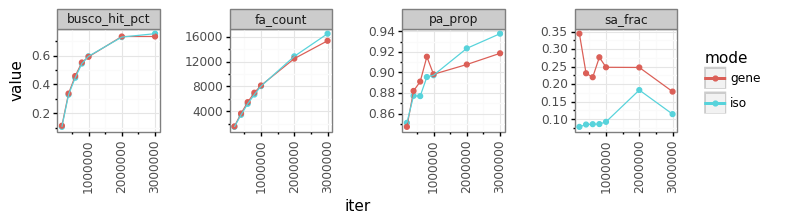

<ggplot: (8746787755745)>

In [344]:
ss_plot_df = pd.melt(ss_count_df.loc[:,['fa_count',
                                     'pa_prop',
                                     'sa_frac',
                                     'busco_hit_pct',
                                     'mode',
                                     'iter',
                                    ]], id_vars=['mode','iter'])

plotnine.options.figure_size = (8,2)
plot = (ggplot(ss_plot_df)
        + theme_bw()
        + theme(aspect_ratio=1,
                axis_text_x = element_text(angle=90),
                panel_spacing = 0.7
               )
        + geom_point(aes('iter','value',color='mode'))
        + geom_line(aes('iter','value',color='mode'))
        + facet_wrap('~variable', ncol = 4, scales='free')
       )
plot

## iterations: iso-level, 1M start, 250k steps

### create cumm fa

In [267]:
base_fa = '/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/1000000/trim/transcriptome_trimmed.fa'
iter_dir = '/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/1000000/trim/iter'
fa_series = sorted(glob.glob(f'{iter_dir}/*/trim/transcriptome_trimmed.fa'))
fa_series_outdir = f'{iter_dir}/cumm_fa'


for idx in range(len(fa_series)):
    counter_list = []
    target_dir = fa_series_outdir + '/' + str(idx)
    print(target_dir)
    if not os.path.exists(target_dir):
        os.mkdir(fa_series_outdir + '/' + str(idx))
    with open(fa_series_outdir + f'/{idx}/cumm_{idx}.fa', 'w') as outf:
        counter = 0
        with open(base_fa, 'r') as infa:
                for line in infa:
                    if line.startswith('>'):
                        line = line.strip() + '_iter_' + '0' + '\n'
                        counter += 1
                    outf.write(line)  
        print('base:', counter)
        counter_list.append(counter)

        for iter_idx,faf in enumerate(fa_series[:idx+1]):
            counter = 0
            with open(faf, 'r') as infa:
                for line in infa:
                    if line.startswith('>'):
                        line = line.strip() + '_iter_' + str(iter_idx+1) + '\n'
                        counter += 1
                    outf.write(line)  
            print(iter_idx, counter)
            counter_list.append(counter)
    print('sum:', sum(counter_list))


/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/1000000/trim/iter/cumm_fa/0
base: 8056
0 6607
sum: 14663
/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/1000000/trim/iter/cumm_fa/1
base: 8056
0 6607
1 8961
sum: 23624
/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/1000000/trim/iter/cumm_fa/2
base: 8056
0 6607
1 8961
2 6071
sum: 29695
/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/1000000/trim/iter/cumm_fa/3
base: 8056
0 6607
1 8961
2 6071
3 3017
sum: 32712
/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/1000000/trim/iter/cumm_fa/4
base: 8056
0 6607
1 8961
2 6071
3 3017
4 440
sum: 33152
/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/1000000/trim/iter/cumm_fa/5
base: 8056
0 6607
1 8961
2 6071
3 3017
4 440
5 5
sum: 33157
/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/1000000/trim/iter/cumm_fa/6
base: 8056
0 6607
1 8961
2 6071
3 3017
4 440
5 5
6 0
sum: 33157
/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/1000000/trim/iter/cumm_fa/7
base: 8056
0 6

### process files

In [288]:
target_dir = fa_series_outdir
        
# fasta scaffold counts
print('ingest cumm fa counts')
fa_counts = []
iter_vals = []
cumm_fa_fs = glob.glob(f'{target_dir}/*/cumm_*.fa')
for f in cumm_fa_fs:
    iter_val = f.split('/')[-2]
    iter_vals.append(iter_val)
    f_count = count_lines(f) // 2
    fa_counts.append(f_count)
    
fa_counts_df = pd.DataFrame({'iter':iter_vals,
                             'fa_count':fa_counts
                            }).astype(int)

# alignment stats
print('ingest mapped counts')
cumm_bam_fs = glob.glob(f'{target_dir}/*/mapped.sorted.bam')
cumm_bam_fs
for f in cumm_bam_fs:
    pa_count = 0
    sa_count = 0
    iter_val = f.split('/')[-2]
    bam_count_fn = f'{target_dir}/{iter_val}/mapped.count'
    if not os.path.exists(bam_count_fn):
        with pysam.AlignmentFile(f, 'rb') as inbam:
            for read in inbam:
                if read.is_supplementary == True:
                    sa_count += 1
                else:
                    pa_count += 1

        with open(bam_count_fn, 'w') as outfile:
            outfile.write(str(iter_val) + '\t' + str(pa_count) + '\t' + str(sa_count))
        print(f, pa_count, sa_count)
    
mapped_counts_df = pd.DataFrame()
cumm_mapped_fs = glob.glob(f'{target_dir}/*/mapped.count')
for f in cumm_mapped_fs:
    df_slice = pd.read_csv(f, header=None, sep='\t').astype(int)
    mapped_counts_df = mapped_counts_df.append(df_slice, ignore_index = True)
mapped_counts_df.columns = ['iter','pa_count','sa_count']
mapped_counts_df = mapped_counts_df.astype(int)

# BUSCO stats
print('ingest BUSCO counts')
busco_df = pd.DataFrame()
iter_vals = []
busco_fs = glob.glob(f'{target_dir}/*/busco/short_summary.specific.eukaryota_odb10.busco.txt')
for f in busco_fs:
    iter_val = f.split('/')[-3]
    iter_vals.append(iter_val)
    df_slice = (pd.read_csv(f, skiprows=8,sep='\t', header=None)
                .loc[:, [1,2]]
                .set_index(2)
                .T
               )
    busco_df = busco_df.append(df_slice, ignore_index = True)
busco_df['iter'] = iter_vals
busco_df = busco_df.astype(int)

# unmapped counts
print('ingest unmapped counts')
unmapped_fs = glob.glob(f'{target_dir}/*/unmapped.fq')
for f in unmapped_fs:
    iter_val = f.split('/')[-2]
    unmapped_count_fn = f'{target_dir}/{iter_val}/unmapped.count'
    if not os.path.exists(unmapped_count_fn):
        f_count = count_lines(f) // 4

        with open(unmapped_count_fn, 'w') as outfile:
            outfile.write(str(iter_val) + '\t' + str(f_count))
        print(f, f_count)

unmapped_counts_df = pd.DataFrame()
cumm_unmapped_fs = glob.glob(f'{target_dir}/*/unmapped.count')
for f in cumm_unmapped_fs:
    df_slice = pd.read_csv(f, header=None, sep='\t').astype(int)
    unmapped_counts_df = unmapped_counts_df.append(df_slice, ignore_index = True)
unmapped_counts_df.columns = ['iter','unmapped_counts']
unmapped_counts_df = unmapped_counts_df.astype(int)

# merge
iter_count_df = fa_counts_df.sort_values('iter')
iter_count_df = pd.merge(iter_count_df, mapped_counts_df, 'left', 'iter')
iter_count_df = pd.merge(iter_count_df, unmapped_counts_df, 'left', 'iter')
iter_count_df = pd.merge(iter_count_df, busco_df, 'left', 'iter')
iter_count_df['scaffold'] = 250000
iter_count_df['total_fq'] = total_input_reads
iter_count_df['busco_missing_pct'] = iter_count_df['Missing BUSCOs (M)']/iter_count_df['Total BUSCO groups searched']
iter_count_df['busco_hit_pct'] = 1-iter_count_df['busco_missing_pct']

iter_count_df['pa_prop'] = iter_count_df['pa_count']/iter_count_df['total_fq']
iter_count_df['sa_frac'] = iter_count_df['sa_count']/(iter_count_df['pa_count']+iter_count_df['sa_count'])

base_slice = (ss_count_df
              .query('mode=="iso"')
              .query('iter==1000000')
              .drop('mode', axis=1)
              .rename(columns={'iter':'scaffold'})
             )
base_slice['iter'] = -1
iter_count_df = iter_count_df.append(base_slice, ignore_index=True)
iter_count_df = iter_count_df.sort_values('iter')
iter_count_df['cumm_scaffold'] = iter_count_df['scaffold'].cumsum()
iter_count_df

ingest cumm fa counts
ingest mapped counts
ingest BUSCO counts
ingest unmapped counts


,Complete BUSCOs (C),Complete and duplicated BUSCOs (D),Complete and single-copy BUSCOs (S),Fragmented BUSCOs (F),Missing BUSCOs (M),Total BUSCO groups searched,busco_hit_pct,busco_missing_pct,fa_count,iter,pa_count,pa_prop,sa_count,sa_frac,scaffold,total_fq,unmapped_counts,cumm_scaffold
8,111,3,108,41,103,255,0.596078,0.403922,8056,-1,15024461,0.897281,1532490,0.092559,1000000,16744426,1719965,1000000
0,138,7,131,56,61,255,0.760784,0.239216,14663,0,15470398,0.923913,1752242,0.101741,250000,16744426,1274028,1250000
1,151,8,143,57,47,255,0.815686,0.184314,23624,1,15510890,0.926332,1845347,0.106322,250000,16744426,1233536,1500000
2,154,10,144,56,45,255,0.823529,0.176471,29695,2,15520949,0.926932,1984735,0.113377,250000,16744426,1223477,1750000
3,154,10,144,58,43,255,0.831373,0.168627,32712,3,15553368,0.928868,2012609,0.114574,250000,16744426,1191058,2000000
4,154,10,144,58,43,255,0.831373,0.168627,33152,4,15557782,0.929132,2016501,0.114742,250000,16744426,1186644,2250000
5,154,10,144,58,43,255,0.831373,0.168627,33157,5,15557839,0.929135,2016554,0.114744,250000,16744426,1186587,2500000
6,154,10,144,58,43,255,0.831373,0.168627,33157,6,15557839,0.929135,2016554,0.114744,250000,16744426,1186587,2750000
7,154,10,144,58,43,255,0.831373,0.168627,33157,7,15557839,0.929135,2016554,0.114744,250000,16744426,1186587,3000000


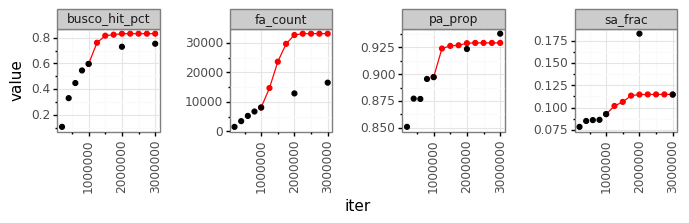

<ggplot: (8747551202497)>

In [289]:
iter_plot_df = pd.melt(iter_count_df.loc[:,['fa_count',
                                     'pa_prop',
                                     'sa_frac',
                                     'busco_hit_pct',
                                     'cumm_scaffold',
                                    ]], id_vars=['cumm_scaffold'])
iter_plot_df = iter_plot_df.rename(columns={'cumm_scaffold':'iter'})

plotnine.options.figure_size = (8,2)
plot = (ggplot(ss_plot_df.query('mode=="iso"'))
        + theme_bw()
        + theme(aspect_ratio=1,
                axis_text_x = element_text(angle=90),
                panel_spacing = 0.7
               )
        
        + geom_point(iter_plot_df, aes('iter','value'), color='red')
        + geom_line(iter_plot_df, aes('iter','value'), color='red')
        
        + geom_point(aes('iter','value'))
        + facet_wrap('~variable', ncol = 4, scales='free')
       )
plot

## merge demuxed bins (generated by C3POA_rev docker)

In [15]:
# cat results of c3poa
run_me = False

if run_me == True:
    output_dir = '/mnt/ibm_lg/daniel_le/data/acoel/full_iter/cumm_fa/5/demux/merge'
    bins_dir = '/mnt/ibm_lg/daniel_le/data/acoel/full_iter/cumm_fa/5/demux/output'

    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)

    partitions = glob.glob(f'{bins_dir}/*/')
    BC_dict = {}
    for partition in tqdm.tqdm(partitions):
        BCs = glob.glob(f'{partition}*/')
        for BC in BCs:
            target = BC.split(partition)[1][:-1]
            source = f'{BC}R2C2_raw_reads.fastq'
            with open(f'{output_dir}/{target}.fq', 'a') as outfile:
                try:
                    with open(source, 'r') as infile:
                        for line in infile:
                            outfile.write(line)
                except:
                    pass


## parse blast results

In [300]:
blast_fs = '/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/3000000/trim/blast.out'

algae_taxid = pd.read_csv('/mnt/ibm_lg/daniel_le/data/blastdb/algae.txids', 
                           names=['taxid'], dtype=int)
algae_taxid['algae'] = True

master_blast = pd.DataFrame()
full_blast = pd.DataFrame()
blast_df = pd.read_csv(blast_fs, 
                       delimiter='\t', 
                       header = None,
                       dtype={0:float,1:int,2:str,3:str,4:str,5:str,6:str,7:str,8:str,9:str,}
                      )
blast_df.columns = ['evalue','qcov','cluster','ssid', 'taxid', 'sci_name', 'common_name', 'blast_name', 'kingdom', 'stitle']
blast_df['taxid'] = [x.split(';')[0] for x in blast_df['taxid']]
blast_df['taxid'] = blast_df['taxid'].astype(int)

# clean-up names
blast_df['stitle'] = [x.lower() for x in blast_df['stitle']]
for substr in [' [', ', ']:
    blast_df['stitle'] = [x if x is np.nan \
                          else x.split(substr)[0] for x in blast_df['stitle']]
for substr in [': ', 'uncharacterized protein ', 'hypothetical protein ', 'putative ']:
    blast_df['stitle'] = [x if x is np.nan \
                          else x.split(substr)[1] if substr in x \
                          else x \
                          for x in blast_df['stitle']]
for substr in [' protein', ' protein ']:
    blast_df['stitle'] = [x if x is np.nan \
                          else ''.join(x.split(substr)) if substr in x \
                          else x \
                          for x in blast_df['stitle']]
blast_df = blast_df.replace(['predicted protein', 'low quality protein','unnamed product'], np.nan)

blast_df = pd.merge(blast_df, algae_taxid, 'left', 'taxid')
blast_df['algae'] = blast_df['algae'].replace(np.nan, False)
full_blast = full_blast.append(blast_df)
blast_df = blast_df.sort_values('evalue', ascending = True).groupby('cluster').head(1)
master_blast = master_blast.append(blast_df, ignore_index=True)


## HTseq gene counts

In [290]:
# GTF format created from fasta
inputfa = '/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/3000000/trim/transcriptome_trimmed.fa'
outputgtf = '/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/3000000/trim/transcriptome_trimmed.gtf'
with pysam.FastaFile(inputfa) as fafile:
    scaffold_lens = fafile.lengths
    ref_names = fafile.references
    
fasta_df = pd.DataFrame({'name':ref_names,
                         'len':scaffold_lens
                        })
fasta_df['source'] = 'manual'
fasta_df['feature'] = 'cns'
fasta_df['start'] = 1
fasta_df['end'] = fasta_df['len'].values
fasta_df['score'] = '.'
fasta_df['strand'] = '+'
fasta_df['frame'] = 0
fasta_df['attribute'] = [f'transcript_id "{x}"; gene_id "{x}";' for x in fasta_df['name']]
fasta_df = fasta_df.loc[:,['name','source','feature',
                           'start','end','score',
                           'strand','frame','attribute'
                          ]]
fasta_df.to_csv(outputgtf,
                sep='\t',
                header=False,
                index=False,
                quotechar='\''
               )

demux_dir = '/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/3000000/trim/demux_map'
for sample_id in range(4,16,1):
    if not os.path.exists(f'{demux_dir}/{sample_id}/htseq.csv'):
        print(sample_id)
        gtf_file = HTSeq.GFF_Reader( outputgtf, end_included=True )
        genebody = HTSeq.GenomicArrayOfSets( "auto", stranded=False )
        counts = {}
        for feature in gtf_file:
            if feature.type in ['cns']:
                genebody[ feature.iv ] += feature.name
                counts[ feature.name ] = 0
        try:
            # parse reads
            sam_file = HTSeq.BAM_Reader(f'{demux_dir}/{sample_id}/mapped.sorted.bam')
            for alnmt in sam_file:
                if alnmt.aligned:
                    iset = None
                    for iv2, step_set in genebody[ alnmt.iv ].steps():
                        if iset is None:
                            iset = step_set.copy()
                        else:
                            iset.intersection_update( step_set )
                    if len( iset ) == 1:
                        counts[ list(iset)[0] ] += 1

            # create df of counts
            gid_list = []
            counts_list = []
            for key,value in counts.items():
                gid_list.append(key)
                counts_list.append(value)

            htseq_df = pd.DataFrame({'gid':gid_list,
                              'count':counts_list
                             })
            htseq_df.to_csv(f'{demux_dir}/{sample_id}/htseq.csv')
        except:
            print('fail')


4
5
6
7
8
9
10
11
12
13
14
15


In [301]:
acoel_clusters = sorted(master_blast.query('algae != True')['cluster'].tolist())
algae_clusters = sorted(master_blast.query('algae == True')['cluster'].tolist())
target_dict = {'acoel':acoel_clusters, 'algae':algae_clusters}

for key,value in target_dict.items():
    master_htseq_df = pd.DataFrame()
    for sample_id in range(4,16,1):
        if sample_id not in [5,14,15]:
            htseq_df = (pd.read_csv(f'{demux_dir}/{sample_id}/htseq.csv', usecols = [1,2], index_col = 0)
                        .T
                       )
            htseq_df['demux_id'] = sample_id
            htseq_df = (htseq_df
                        .set_index('demux_id')
                       )
            master_htseq_df = master_htseq_df.append(htseq_df)

    master_htseq_df = master_htseq_df.T
    # sample-wise ranked expression to control for differences in read depth
    master_htseq_df = (master_htseq_df
                       .loc[value, :]
                       .dropna()
                       .rank(axis=0, pct=True, method='dense')
                      )

    # pd df to np array
    array_adata = master_htseq_df.values

    # extract obs and var
    obs = [f'sample_{x}' for x in master_htseq_df.columns]
    gene_names = master_htseq_df.index.tolist()

    # create ad obj
    adata = ad.AnnData(X=array_adata).T
    adata.X = sparse.csr_matrix(adata.X)
    adata.var_names = gene_names
    adata.obs_names = obs

    # append metadata
    adata.obs['sample_desc'] = ['0A2',
                                '0P2',
                                '0P3',
                                '0P4',
                                '3P1',
                                '3P2',
                                '3P3',
                                '6P3',
                                '6P6']

    adata.obs['timepoint'] = [x[0] for x in adata.obs['sample_desc']]
    adata.obs['region'] = [x[1] for x in adata.obs['sample_desc']]
    adata.obs['index'] = [x[2] for x in adata.obs['sample_desc']]

    # transform and freeze raw state
    adata.raw = sc.pp.log1p(adata, copy=True)
    exec(f'{key}_adata = adata')
    exec(f'{key}_htseq_df = master_htseq_df')


## DE analysis

In [348]:
target = 6
ref = 0
test_type = 't-test'

input_adata = acoel_adata
input_adata = input_adata[input_adata.obs.sample_desc != '0A2']
sc.tl.rank_genes_groups(input_adata, 
                        groups = [str(target)],
                        reference = str(ref),
                        groupby='timepoint', 
                        method=test_type,
                        n_genes=len(input_adata.var_names)
                       )
results_df = pd.DataFrame()
# target = adata.uns['rank_genes_groups']['pvals_adj'].dtype.names
results_df = pd.DataFrame({'cluster':[x[0] for x in input_adata.uns['rank_genes_groups']['names'].tolist()],
                            'logfc':[x[0] for x in input_adata.uns['rank_genes_groups']['logfoldchanges'].tolist()],
                            'adj_pval':[x[0] for x in input_adata.uns['rank_genes_groups']['pvals_adj'].tolist()],
                            'pval':[x[0] for x in input_adata.uns['rank_genes_groups']['pvals'].tolist()],

                          })

results_df = pd.merge(results_df.sort_values('pval'),
         (master_blast
          .loc[:,['stitle','cluster','blast_name','algae']]
         ),
         'left',
         'cluster'
        )
results_df['idx'] = [x for x in range(len(results_df))]
results_df['algae'] = results_df['algae'].replace(np.nan, False)
results_df.head(50)

Trying to set attribute `.obs` of view, making a copy.
... storing 'timepoint' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'region' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'index' as categorical


,cluster,logfc,adj_pval,pval,stitle,blast_name,algae,idx
0,cluster_14322,0.419949,0.466076,0.000102,coiled-coil domain-containing 124,beetles,False,0
1,cluster_10055,1.484287,0.466076,0.000168,phenylalanine--trna ligase,bony fishes,False,1
2,cluster_10343,1.821646,0.466076,0.000227,loc101861588,gastropods,False,2
3,cluster_13400,-0.553694,0.466076,0.000245,transcription initiation factor iib-like,spiders,False,3
4,cluster_4121,-0.957150,0.466076,0.000360,e2f-associated phosphoprotein-like,hemichordates,False,4
5,cluster_13010,-0.968903,0.466076,0.000361,protein polybromo-1-like,cephalopods,False,5
6,cluster_8867,-0.968903,0.466076,0.000361,recombining binding suppressor of hairless iso...,birds,False,6
7,cluster_4247,-1.353104,0.466076,0.000376,stromal interaction molecule 2,bony fishes,False,7
8,cluster_5346,-1.114437,0.476519,0.000438,39s ribosomal l12,cephalopods,False,8
9,cluster_260,-0.891399,0.476519,0.000480,malignant fibrous histiocytoma-amplified seque...,bony fishes,False,9


,0A2,0P2,0P3,0P4,3P1,3P2,3P3,6P3,6P6
gid,,,,,,,,,
cluster_1139,0.018349,0.021605,0.036424,0.037464,0.116352,0.105932,0.129231,0.131086,0.142433


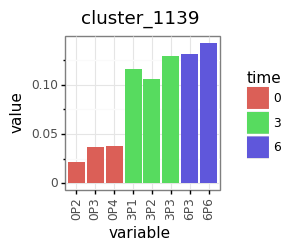

<ggplot: (8746981895365)>

,evalue,qcov,cluster,ssid,taxid,sci_name,common_name,blast_name,kingdom,stitle,algae
1495318,1.850000e-40,18,cluster_1139,ref|XP_032516528.1|,278856,Danaus plexippus plexippus,Danaus plexippus plexippus,butterflies,Eukaryota,early growth response 3 isoform x2,False
1495319,4.730000e-40,18,cluster_1139,ref|XP_032516527.1|,278856,Danaus plexippus plexippus,Danaus plexippus plexippus,butterflies,Eukaryota,early growth response 3 isoform x1,False
1495320,8.300000e-40,18,cluster_1139,ref|XP_026748877.1|,7137,Galleria mellonella,greater wax moth,moths,Eukaryota,early growth response 3 isoform x2,False
1495321,8.930000e-40,18,cluster_1139,ref|XP_013173557.1|,66420,Papilio xuthus,Asian swallowtail,butterflies,Eukaryota,early growth response 2,False
1495322,1.020000e-39,17,cluster_1139,ref|XP_023934113.1|,110368,Bicyclus anynana,squinting bush brown,butterflies,Eukaryota,e3 sumo-protein ligase egr2 isoform x2,False
1495323,1.050000e-39,18,cluster_1139,ref|XP_013138182.1|,76194,Papilio polytes,common Mormon,butterflies,Eukaryota,early growth response 2,False
1495324,1.080000e-39,18,cluster_1139,ref|XP_022122551.1|,64459,Pieris rapae,cabbage white,butterflies,Eukaryota,early growth response 3-like isoform x2,False
1495325,1.170000e-39,18,cluster_1139,ref|XP_014362719.1|,76193,Papilio machaon,common yellow swallowtail,butterflies,Eukaryota,e3 sumo-protein ligase egr2,False
1495326,1.260000e-39,18,cluster_1139,ref|XP_026318962.1|,1477025,Hyposmocoma kahamanoa,Hyposmocoma kahamanoa,moths,Eukaryota,early growth response 2-like isoform x2,False
1495327,1.480000e-39,18,cluster_1139,ref|XP_026498625.1|,334116,Vanessa tameamea,Vanessa tameamea,butterflies,Eukaryota,early growth response 3 isoform x2,False


/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 9 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 9 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


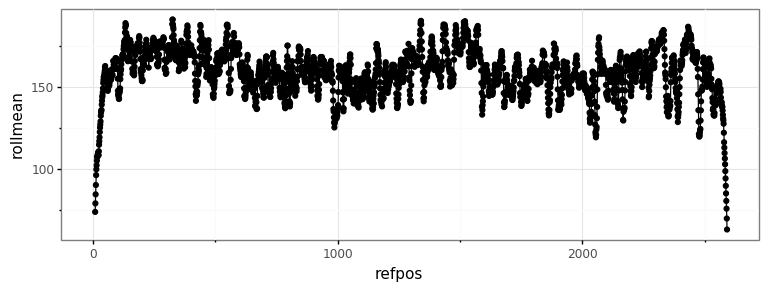

<ggplot: (8747149833489)>


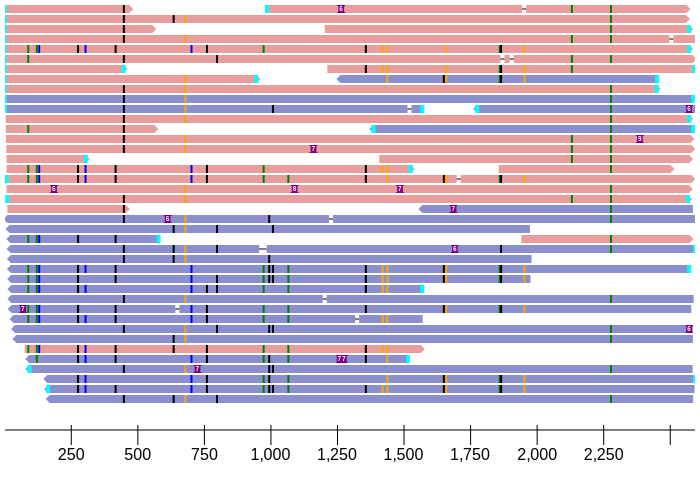

In [349]:
species_target = 'acoel'
gid = 'cluster_1139'
inputbam = '/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/3000000/trim/mapped.sorted.bam'


# show contig ranked expression level
exec(f'input_htseq_df = {species_target}_htseq_df')
slice_df = input_htseq_df[input_htseq_df.index == gid]
slice_df.columns = adata.obs.sample_desc.tolist()
display(slice_df)

# plot bar plot of DE
plot_df = pd.melt(slice_df.drop('0A2', 1))
plot_df['time'] = [x[0] for x in plot_df['variable']]
plotnine.options.figure_size=(2,2)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle=90))
        + geom_bar(aes('variable','value',fill='time'),stat='identity')
        + ggtitle(gid)
       )
display(plot)

# show top blast hits
display(full_blast[full_blast['cluster'] ==  gid].sort_values(['evalue','qcov']).head(10))


# plot coverage
clust_id = gid
minlen = 500
frac = 0.33
window = 10

with pysam.FastaFile(inputfa) as fafile:
    clust_seq = fafile.fetch(clust_id).strip()
    seq_len = len(clust_seq)
    cov_list=[]
    pos_list=[]
    with pysam.AlignmentFile(inputbam, "rb" ) as bamfile:
        for c in bamfile.pileup(reference=clust_id):
            pos_list.append(c.reference_pos)
            real_cov = 0
            for pileupread in c.pileups:
                if not pileupread.is_del and not pileupread.is_refskip:
                    real_cov += 1
            cov_list.append(real_cov)

        # must have at least 1 read to keep cluster and len greater than minlen
        if any([x>0 for x in cov_list]) and len(pos_list) >= minlen:
            cov_df = pd.DataFrame({'cov':cov_list,'refpos':pos_list})
            cov_df['rollmean'] = cov_df['cov'].rolling(window).mean()
            # require > 10% of max rolling mean
            cov_df['passing'] = [x > (frac*np.max(cov_df['rollmean'])) for x in cov_df['rollmean']]

cov_df['group'] = 1
plotnine.options.figure_size=(9,3)
plot = (ggplot(cov_df)
        + theme_bw()
        + geom_point(aes('refpos','rollmean'))
        + geom_line(aes('refpos','rollmean',group='group'))
       )
print(plot)

# create tmp bam to downsample
outputbam = '/mnt/ibm_lg/daniel_le/data/acoel/tmp/tmp.bam' 
outputsortedbam = '/mnt/ibm_lg/daniel_le/data/acoel/tmp/tmp.sorted.bam' 
sample_n = 50

with pysam.AlignmentFile(inputbam) as bam:
    with pysam.AlignmentFile(outputbam, "wb", template=bam) as output:

        read_idx_list = []
        for idx, read in enumerate(bam.fetch(clust_id)):
            read_idx_list.append(idx)
        random.shuffle(read_idx_list)
        read_idx_list = read_idx_list[:sample_n]

        for idx, read in enumerate(bam.fetch(clust_id)):
            if idx in read_idx_list:
                output.write(read)

pysam.index(outputbam)

doc = genomeview.visualize_data([outputbam], clust_id, 1, seq_len, inputfa, width=700)
display(doc)

## Algae contig analysis

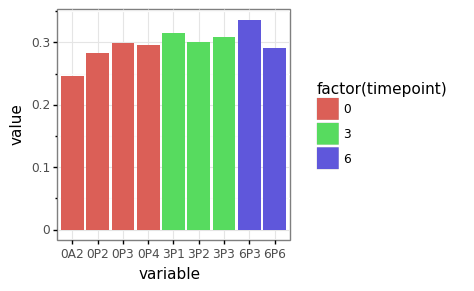

<ggplot: (8747123908765)>


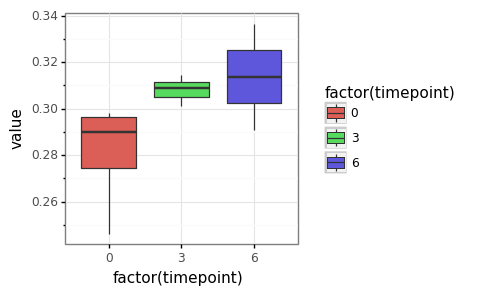

<ggplot: (8747573334477)>


In [307]:
master_htseq_df = pd.DataFrame()
for sample_id in range(4,16,1):
    if sample_id not in [5,14,15]:
        htseq_df = (pd.read_csv(f'{demux_dir}/{sample_id}/htseq.csv', usecols = [1,2], index_col = 0)
                    .T
                   )
        htseq_df['demux_id'] = sample_id
        htseq_df = (htseq_df
                    .set_index('demux_id')
                   )
        master_htseq_df = master_htseq_df.append(htseq_df)

master_htseq_df = master_htseq_df.T
master_htseq_df['algae'] = [x in algae_clusters for x in master_htseq_df.index]
master_htseq_df = master_htseq_df.groupby('algae').sum() / master_htseq_df.groupby('algae').sum().sum()
master_htseq_df.columns = ['0A2','0P2','0P3','0P4','3P1','3P2','3P3','6P3','6P6']
master_htseq_df = master_htseq_df.reset_index().query('algae == True')
master_htseq_df = pd.melt(master_htseq_df, id_vars='algae')
master_htseq_df['timepoint'] = [int(x[0]) for x in master_htseq_df['variable']]
master_htseq_df['loc_id'] = [x[1] for x in master_htseq_df['variable']]
master_htseq_df['sample_index'] = [int(x[2]) for x in master_htseq_df['variable']]

plotnine.options.figure_size=(3,3)
plot = (ggplot(master_htseq_df)
        + theme_bw()
        + geom_bar(aes('variable','value',fill='factor(timepoint)'), stat='identity')
       )
print(plot)

plot = (ggplot(master_htseq_df)
        + theme_bw()
        + geom_boxplot(aes('factor(timepoint)','value',fill='factor(timepoint)'))
       )
print(plot)

# Short-read data

In [384]:
# ingest STAR gene count ouputs
gene_count_fns = glob.glob('/mnt/ibm_lg/daniel_le/data/acoel/short_read/aln/*_ReadsPerGene.out.tab')

short_read_counts = pd.DataFrame()
for fn in sorted(gene_count_fns):
    sample_prefix = fn.split('/')[-1].split('_')[0]
    count_slice = pd.read_csv(fn, delimiter='\t', header=None, skiprows=[0,1,2,3])
    count_slice.columns = ['contig','unstranded','stranded_0', 'stranded_1']
    short_read_counts[sample_prefix] = count_slice['unstranded'].values
    
short_read_counts.index = count_slice['contig'].values
short_read_counts = short_read_counts.rank(pct=True)
short_read_counts = short_read_counts.drop('0A2', 1)

In [388]:
pd.DataFrame(short_read_counts.loc[gid,:]).reset_index()

,index,cluster_1139
0,0P2,0.452838
1,0P3,0.495881
2,0P4,0.682256
3,3P1,0.957442
4,3P2,0.952323
5,3P3,0.957715
6,6P3,0.954868
7,6P6,0.947083


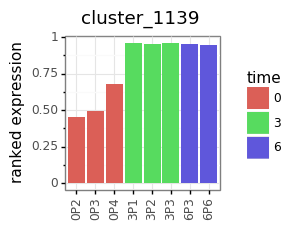

<ggplot: (8746996925929)>

In [391]:
# plot bar plot of DE
gid = 'cluster_1139'
plot_df = pd.DataFrame(short_read_counts.loc[gid,:]).reset_index()
plot_df['time'] = [x[0] for x in plot_df['index']]
plotnine.options.figure_size=(2,2)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(axis_text_x = element_text(angle=90))
        + geom_bar(aes('index',gid,fill='time'),stat='identity')
        + ggtitle(gid)
        + ylab('ranked expression')
        + xlab('')
       )
display(plot)


# IN DEVELOPMENT

## supplemental alignment analysis

In [308]:
ref_list = []
sa_list = []
with pysam.AlignmentFile(inputbam, 'rb') as inbam:
    for read in inbam:
        ref = read.reference_name
        if read.is_supplementary == True:
            ref_list.append(ref)
            tags = read.get_tags()
            for x in tags: 
                if 'SA' in x:
                    SA_tag = x[1]
                    SA_scaffold = SA_tag.split(',')[0]
            sa_list.append(SA_scaffold)

supp_df = pd.DataFrame({'ref':ref_list, 'sa':sa_list})
supp_df = (pd.DataFrame(supp_df
           .groupby('ref')['sa']
           .value_counts()
            ).rename(columns = {'sa':'sa_count'})
             .reset_index()
             .sort_values('sa_count', ascending=False)
            )

master_htseq_df = pd.DataFrame()
for sample_id in range(4,16,1):
    if sample_id not in [5,14,15]:
        htseq_df = (pd.read_csv(f'{demux_dir}/{sample_id}/htseq.csv', usecols = [1,2], index_col = 0)
                    .T
                   )
        htseq_df['demux_id'] = sample_id
        htseq_df = (htseq_df
                    .set_index('demux_id')
                   )
        master_htseq_df = master_htseq_df.append(htseq_df)

for i in ['ref','sa']:
    supp_df = pd.merge(supp_df, 
                       pd.DataFrame(master_htseq_df.sum()).reset_index().rename(columns = {'gid':i, 0:f'{i}_all'}),
                       'left',
                       i
                      )
    supp_df = pd.merge(supp_df, 
                        (master_blast
                              .loc[:,['stitle','cluster']]
                                 .rename(columns = {'cluster':i, 'stitle':f'{i}_stitle'})
                             ),
                       'left',
                       i
                      )
supp_df['total'] = supp_df['ref_all'] + supp_df['sa_all']
supp_df['sa_frac'] = supp_df['sa_count']/(supp_df['total']/2)
supp_df = supp_df.sort_values('sa_frac', ascending = False)
supp_df['match_coverage'] = [np.nan if x is np.nan or y is np.nan \
                             else similar(x,y) \
                             for x,y in zip(supp_df['ref_stitle'],supp_df['sa_stitle'])]

/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 1 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


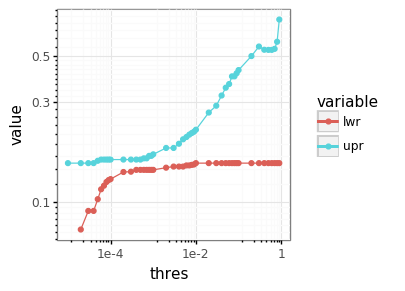

<ggplot: (8747169952833)>

In [309]:
# determine heuristic threshold based on blast matching
upper_list = []
lower_list =[]
thres_list = []
for x in [y for y in range(1,11)]+[y*10 for y in range(2,11)]+ \
[y*100 for y in range(2,11)]+[y*1000 for y in range(2,11)] + [y*10000 for y in range(2,10)]:
    x = x/100000
    upper_list.append(supp_df.query(f'sa_frac >= {x}')['match_coverage'].median())
    lower_list.append(supp_df.query(f'sa_frac < {x}')['match_coverage'].median())
    thres_list.append(x)
plot_df = pd.DataFrame({'thres':thres_list, 'upr':upper_list, 'lwr':lower_list})

plotnine.options.figure_size = (3,3)
plot = (ggplot(pd.melt(plot_df, id_vars='thres'))
        + theme_bw()
        + geom_point(aes('thres','value',color='variable'))
        + geom_line(aes('thres','value',color='variable'))
        + scale_x_log10()
        + scale_y_log10()
       )
plot

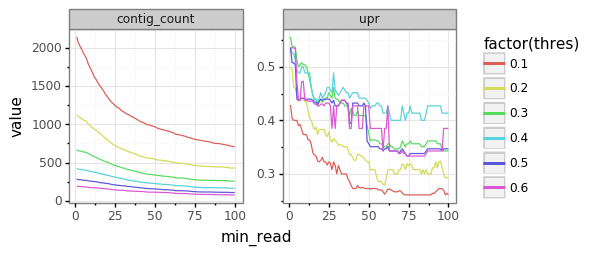

<ggplot: (8747269673781)>

In [312]:
# determine heuristic threshold based on blast matching as function of min read cutoff

upper_list = []
min_read_list = []
contig_count_list = []
thres_list = []
for min_read in range(1,101):
    for x in [10000,20000,30000,40000,50000,60000]:
        x = x/100000
        upper_list.append(supp_df.query(f'sa_frac >= {x} and sa_count >= {min_read}')['match_coverage'].median())
        contig_count_list.append(len(supp_df.query(f'sa_frac >= {x} and sa_count >= {min_read}')))
        min_read_list.append(min_read)
        thres_list.append(x)
plot_df = pd.DataFrame({'min_read':min_read_list, 'upr':upper_list, 
                        'contig_count':contig_count_list,'thres':thres_list})

plotnine.options.figure_size = (5,3)
plot = (ggplot(pd.melt(plot_df, id_vars = ['min_read','thres']))
        + theme_bw()
        + theme(aspect_ratio = 1,
                panel_spacing = 0.4
               )
#         + geom_point(aes('min_read','value',color='variable'))
        + geom_line(aes('min_read','value',color='factor(thres)'))
        + facet_wrap('~variable', scales = 'free')
       )
plot

In [313]:
# extract target pairs
min_frac = 0.4
min_link = 1
target_rows = (supp_df.query(f'sa_frac >= {min_frac} and sa_count >= {min_link}')
               .reset_index()
               .drop('index', 1)
               .sort_values(['ref','sa'])
              )
pair_list = [[x,y] for x,y in zip(target_rows['ref'], target_rows['sa'])]
possible_contigs = [ele for sublist in pair_list for ele in sublist]
possible_contigs = list(set(possible_contigs))
print(len(possible_contigs))

# test
# x = possible_contigs[3]
# display([sublist for sublist in pair_list if x in sublist])
# supp_df.query(f'ref == "{x}" or sa == "{x}"')

848


In [314]:
# create contig networks
cluster_lists = []
# testing
# pair_list = [['a','b'], ['a','c'], ['d','e'],['c','a']]
# possible_contigs = [ele for sublist in pair_list for ele in sublist]
possible_contigs = list(set(possible_contigs))

for key in possible_contigs:
    contig_cluster = [key]
    current_step = contig_cluster
    # step1: look for partners
    if len(current_step) > 0:
        next_step = []
        for x in current_step:
            match_list = [sublist for sublist in pair_list if x in sublist]
            match_list = [ele for sublist in match_list for ele in sublist]
            for y in match_list:
                if y not in contig_cluster:
                    contig_cluster.append(y)
                    next_step.append(y)
                
        current_step = next_step

    cluster_lists.append(frozenset(contig_cluster))

cluster_lists = [list(x) for x in set(cluster_lists)]
print(len(cluster_lists))


257


In [315]:
poa_dir = '/mnt/ibm_lg/daniel_le/data/acoel/nanofilt_single/iso/3000000/trim/collapse'

# create fastas based on contig networks
contig_name = []
seq = []
with open(inputfa, 'r') as infa:
    for line in infa:
        if line.startswith('>'):
            contig_name.append(line.strip()[1:])
        else:
            seq.append(line.strip())
            
fa_df = pd.DataFrame({'contig':contig_name,'seq':seq})

for idx1, sublist in enumerate(cluster_lists):
    with open(f'{poa_dir}/{idx1}.fa','w') as outfa:
        for idx2, contig in enumerate(sublist):
            seq = fa_df.query(f'contig == "{contig}"')['seq'].tolist()[0]
            outfa.write(f'>contig_{idx1}_{idx2}' + '\n' + seq + '\n')
            
# run SPOA to create consensus reads
# BASH: spoa <input.fa> > input.fa.poa
# cd /mnt/ibm_lg/daniel_le/data/acoel/full_iter/cumm_fa/5/fa_collapse
# for i in $(ls); do spoa $i > ${i}.poa; done

In [316]:
# merge poa consensi
poa_files = glob.glob(f'{poa_dir}/*.fa.poa')
with open(f'{poa_dir}/merge.fa', 'w') as outfa:
    for idx, poa_file in enumerate(poa_files):
        with open(poa_file,'r') as infa:
            for line_idx, line in enumerate(infa):
                if line_idx == 1:
                    seq = line.strip()
                    outfa.write(f'>contig_{idx}' + '\n' + seq + '\n')

In [317]:
# create trimmed fasta, omitting collapsed contigs
trimmed_fa_df = fa_df[[x not in possible_contigs for x in fa_df.contig]]
trimmed_fa_df = trimmed_fa_df.reset_index().drop('index', 1)

with open(f'{poa_dir}/trimmed.fa', 'w') as outfa:
    for x in range(len(trimmed_fa_df)):
        df_slice = trimmed_fa_df.iloc[x, :]
        contig_name = df_slice['contig']
        seq = df_slice['seq']
        outfa.write(f'>{contig_name}' + '\n' + seq + '\n')

# cat merge.fa trimmed.fa > polished.fa

## process polished fa

In [319]:
parent_dir = poa_dir
print('ingest cumm fa counts')
fa_counts = []
cumm_fa_fs = glob.glob(f'{parent_dir}/polished.fa')
for f in cumm_fa_fs:
    f_count = count_lines(f) // 2
    fa_counts.append(f_count)
    
fa_counts_df = pd.DataFrame({
                             'fa_count':fa_counts,
                            })
fa_counts_df = fa_counts_df.astype({'fa_count':int,
                                   })
fa_counts_df['iter'] = 'Polish'

print('ingest mapped counts')
cumm_bam_fs = glob.glob(f'{parent_dir}/mapped.sorted.bam')
for f in cumm_bam_fs:
    pa_count = 0
    sa_count = 0
    bam_count_fn = f'{parent_dir}/mapped.count'
    if not os.path.exists(bam_count_fn):
        with pysam.AlignmentFile(f, 'rb') as inbam:
            for read in inbam:
                if read.is_supplementary == True:
                    sa_count += 1
                else:
                    pa_count += 1

        with open(bam_count_fn, 'w') as outfile:
            outfile.write(str(pa_count) + '\t' + str(sa_count))
        print(f, pa_count, sa_count)
    
mapped_counts_df = pd.DataFrame()
cumm_mapped_fs = glob.glob(f'{parent_dir}/mapped.count')
for f in cumm_mapped_fs:
    df_slice = pd.read_csv(f, header=None, sep='\t')
    mapped_counts_df = mapped_counts_df.append(df_slice, ignore_index = True)
mapped_counts_df.columns = ['pa_count','sa_count']
mapped_counts_df = mapped_counts_df.astype({
                                            'pa_count':int,
                                            'sa_count': int,})
mapped_counts_df['iter'] = 'Polish'

print('ingest unmapped counts')
unmapped_fs = glob.glob(f'{parent_dir}/unmapped.fq')
for f in unmapped_fs:
    unmapped_count_fn = f'{parent_dir}/unmapped.count'
    if not os.path.exists(unmapped_count_fn):
        f_count = count_lines(f) // 4

        with open(unmapped_count_fn, 'w') as outfile:
            outfile.write(str(f_count))
        print(f, f_count)

unmapped_counts_df = pd.DataFrame()
cumm_unmapped_fs = glob.glob(f'{parent_dir}/unmapped.count')
for f in cumm_unmapped_fs:
    df_slice = pd.read_csv(f, header=None, sep='\t')
    unmapped_counts_df = unmapped_counts_df.append(df_slice, ignore_index = True)
unmapped_counts_df.columns = ['unmapped_counts']
unmapped_counts_df = unmapped_counts_df.astype({'unmapped_counts':int,
                                               })
unmapped_counts_df['iter'] = 'Polish'

print('ingest BUSCO counts')
busco_df = pd.DataFrame()
busco_fs = glob.glob(f'{parent_dir}/busco/short_summary.specific.eukaryota_odb10.busco.txt')
for f in busco_fs:
    df_slice = (pd.read_csv(f, skiprows=8,sep='\t', header=None)
                .loc[:, [1,2]]
                .set_index(2)
                .T
               )
    busco_df = busco_df.append(df_slice, ignore_index = True)
busco_df = busco_df.astype(int)
busco_df['iter'] = 'Polish'

polish_df = fa_counts_df.sort_values('iter')
polish_df = pd.merge(polish_df, mapped_counts_df, 'left', ['iter'])
polish_df = pd.merge(polish_df, unmapped_counts_df, 'left', ['iter'])
polish_df = pd.merge(polish_df, busco_df, 'left', ['iter'])

polish_df['total_fq'] = total_input_reads
polish_df['busco_missing_pct'] = polish_df['Missing BUSCOs (M)']/polish_df['Total BUSCO groups searched']
polish_df['busco_hit_pct'] = 1-polish_df['busco_missing_pct']

polish_df['pa_prop'] = polish_df['pa_count']/polish_df['total_fq']
polish_df['sa_frac'] = polish_df['sa_count']/(polish_df['pa_count']+polish_df['sa_count'])


ingest cumm fa counts
ingest mapped counts
ingest unmapped counts
ingest BUSCO counts


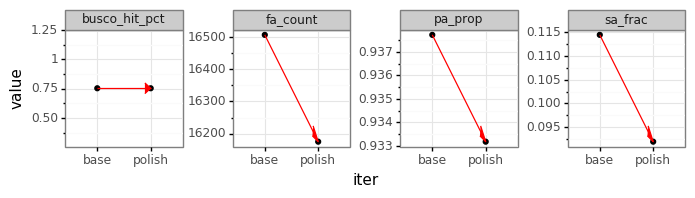

<ggplot: (8746810172289)>

In [336]:
plot_df = pd.melt((ss_count_df
                  .query('mode == "iso"')
                   .query('iter == 3000000')
                   .append(polish_df)
                   .loc[:,['iter','busco_hit_pct','fa_count','pa_prop','sa_frac']]
                  ), id_vars='iter')
plot_df['iter'] = plot_df['iter'].replace(3000000, 'base').replace('Polish', 'polish')
plot_df['group'] = 1

plotnine.options.figure_size = (8,3)
plot = (ggplot(plot_df)
        + theme_bw()
        + theme(panel_spacing = 0.5,
                aspect_ratio = 1
               )
        + geom_point(aes('iter','value'))
        + geom_line(aes('iter','value', group = 1),
                    color = 'red',
                    arrow=plotnine.geoms.arrow(angle=10, length=0.4, 
                                               ends='last', type='closed'))
        + facet_wrap('~variable', scales = 'free', ncol = 4)
       )

plot

## Liftover mapping analysis
downsample to 1M reads

In [209]:
outdir = '/mnt/ibm_lg/daniel_le/data/acoel/full_iter/cumm_fa/5/H_miamia_lift'
acoel_contigs = master_blast.query('algae == False').cluster.tolist()
algae_contigs = master_blast.query('algae == True').cluster.tolist()
unk_contigs = list(set(fa_df.contig)-set(acoel_contigs+algae_contigs))

label_dict = {'acoel':acoel_contigs,
              'algae':algae_contigs,
              'unk':unk_contigs
             }

for key,value in label_dict.items():

    trimmed_fa_df = fa_df[[x not in value for x in fa_df.contig]]
    trimmed_fa_df = trimmed_fa_df.reset_index().drop('index', 1)

    with open(f'{outdir}/{key}_contig.fa', 'w') as outfa:
        for x in range(len(trimmed_fa_df)):
            df_slice = trimmed_fa_df.iloc[x, :]
            contig_name = df_slice['contig']
            seq = df_slice['seq']
            outfa.write(f'>{contig_name}' + '\n' + seq + '\n')

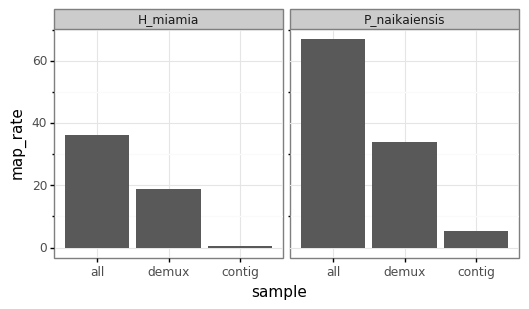

<ggplot: (8747263679177)>

In [236]:
H_miamia_stats = pd.DataFrame({'sample':['contig','raw','demux'],
                               'map_rate':[0.46,36.17,18.73]
                              })
H_miamia_stats['species'] = 'H_miamia'
P_miamia_stats = pd.DataFrame({'sample':['contig','raw','demux'],
                               'map_rate':[5.49,66.88,33.82]
                              })
P_miamia_stats['species'] = 'P_naikaiensis'
stats_df = H_miamia_stats.append(P_miamia_stats)

stats_df['sample'] = (stats_df['sample']
                            .astype(str)
                            .astype(CategoricalDtype(['all','demux','contig'],ordered=True))
                           )

plotnine.options.figure_size = (6,2)
plot = (ggplot(stats_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_bar(aes('sample','map_rate'), stat='identity')
        + facet_wrap('~species')
       )
plot

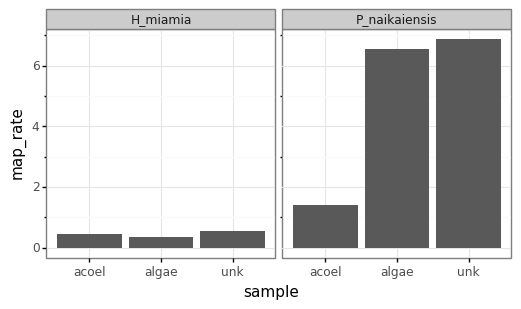

<ggplot: (8746837425725)>

In [238]:
H_miamia_stats = pd.DataFrame({'sample':['unk','acoel','algae'],
                               'map_rate':[0.56,0.45,0.36]
                              })
H_miamia_stats['species'] = 'H_miamia'
P_miamia_stats = pd.DataFrame({'sample':['unk','acoel','algae'],
                               'map_rate':[6.86,1.42,6.54]
                              })
P_miamia_stats['species'] = 'P_naikaiensis'
stats_df = H_miamia_stats.append(P_miamia_stats)

stats_df['sample'] = (stats_df['sample']
                            .astype(str)
                            .astype(CategoricalDtype(['acoel','algae','unk',],ordered=True))
                           )

plotnine.options.figure_size = (6,2)
plot = (ggplot(stats_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_bar(aes('sample','map_rate'), stat='identity')
        + facet_wrap('~species')
       )
plot

## export DE results

In [354]:
test_type = 't-test'
target_ref_tuples = [(3,0), 
                   (6,0), 
                   (6,3)]
for species in ['algae','acoel']:
    for tup in target_ref_tuples:
        target = tup[0]
        ref = tup[1]
        print(species, target, ref)
        exec(f'input_adata = {species}_adata')
        input_adata = input_adata[input_adata.obs.sample_desc != '0A2']
        sc.tl.rank_genes_groups(input_adata, 
                                groups = [str(target)],
                                reference = str(ref),
                                groupby='timepoint', 
                                method=test_type,
                                n_genes=len(input_adata.var_names)
                               )
        results_df = pd.DataFrame()
        # target = adata.uns['rank_genes_groups']['pvals_adj'].dtype.names
        results_df = pd.DataFrame({'cluster':[x[0] for x in input_adata.uns['rank_genes_groups']['names'].tolist()],
                                    'logfc':[x[0] for x in input_adata.uns['rank_genes_groups']['logfoldchanges'].tolist()],
                                    'adj_pval':[x[0] for x in input_adata.uns['rank_genes_groups']['pvals_adj'].tolist()],
                                    'pval':[x[0] for x in input_adata.uns['rank_genes_groups']['pvals'].tolist()],

                                  })

        results_df = pd.merge(results_df.sort_values('pval'),
                 (master_blast
                  .loc[:,['stitle','cluster','blast_name','algae']]
                 ),
                 'left',
                 'cluster'
                )
        results_df['idx'] = [x for x in range(len(results_df))]
        results_df['algae'] = results_df['algae'].replace(np.nan, False)
        results_df.to_csv(f'/home/daniel_le/data/acoel_de/update_1/de_{species}_target_{target}_ref_{ref}.csv', index=False)


Trying to set attribute `.obs` of view, making a copy.
... storing 'timepoint' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'region' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'index' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'timepoint' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'region' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'index' as categorical


algae 3 0
algae 6 0
algae 6 3


Trying to set attribute `.obs` of view, making a copy.
... storing 'timepoint' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'region' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'index' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'timepoint' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'region' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'index' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'timepoint' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'region' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'index' as categorical


acoel 3 0
acoel 6 0


Trying to set attribute `.obs` of view, making a copy.
... storing 'timepoint' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'region' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'index' as categorical


acoel 6 3
